2024-07-17 03:15:11.546547: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 03:15:11.553880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 03:15:11.563076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 03:15:11.565730: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 03:15:11.572341: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


I0000 00:00:1721178912.806442    6890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721178912.825346    6890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721178912.825465    6890 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721178912.827502    6890 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

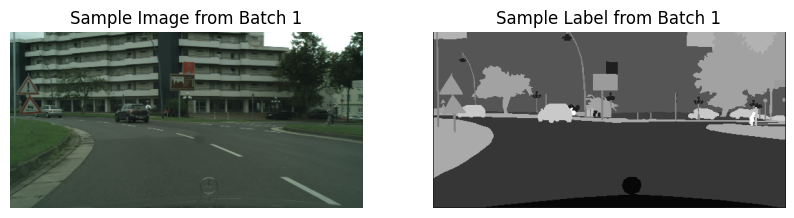

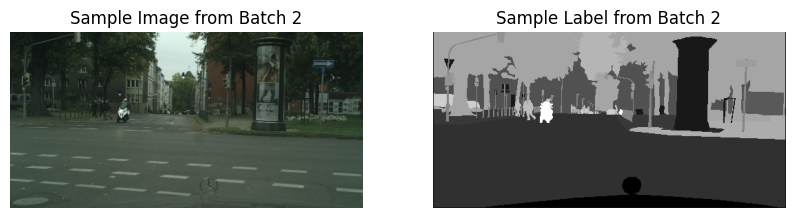

2024-07-17 03:15:13.422356: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

data_dir = '/home/maith/Desktop/cityscapes'
train_images_dir = os.path.join(data_dir, 'leftImg8bit/train')
train_labels_dir = os.path.join(data_dir, 'gtFine/train')

def preprocess_image(image_path, label_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.squeeze(label)
    return image, tf.cast(label, tf.int32)

def augment(image, label):
    label = tf.expand_dims(label, axis=-1)
    
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    label = tf.squeeze(label, axis=-1)

    return image, label


def file_paths_generator():
    count = 0
    for city in sorted(os.listdir(train_images_dir)):
        city_images_path = os.path.join(train_images_dir, city)
        city_labels_path = os.path.join(train_labels_dir, city)
        for image_name in sorted(os.listdir(city_images_path)):
            if image_name.endswith('_leftImg8bit.png'):
                image_path = os.path.join(city_images_path, image_name)
                label_name = image_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
                label_path = os.path.join(city_labels_path, label_name)
                count += 1
                yield image_path, label_path
    print(f'Total images processed: {count}')

def create_dataset():
    dataset = tf.data.Dataset.from_generator(
        generator=file_paths_generator,
        output_types=(tf.string, tf.string),
        output_shapes=((), ()))

    dataset = dataset.map(lambda x, y: preprocess_image(x, y))
    return dataset.repeat()

dataset = create_dataset().batch(8).prefetch(buffer_size=tf.data.AUTOTUNE)

try:
    for batch, (images, labels) in enumerate(dataset.take(2)):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title(f'Sample Image from Batch {batch+1}')
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'Sample Label from Batch {batch+1}')
        plt.imshow(labels[0].numpy().squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()
except tf.errors.OutOfRangeError:
    print("Attempted to access beyond the available data.")

In [2]:
import os
import numpy as np
import tensorflow as tf

data_dir = '/home/maith/Desktop/cityscapes'
train_labels_dir = os.path.join(data_dir, 'gtFine/train')

def analyze_dataset(train_labels_dir):
    class_ids = []
    for city in sorted(os.listdir(train_labels_dir)):
        city_labels_path = os.path.join(train_labels_dir, city)
        for label_file in sorted(os.listdir(city_labels_path)):
            if label_file.endswith('_labelIds.png'):
                label_path = os.path.join(city_labels_path, label_file)
                label = tf.io.read_file(label_path)
                label = tf.image.decode_png(label, channels=1)
                unique_ids = np.unique(label.numpy())
                class_ids.extend(unique_ids)
    
    unique_class_ids = np.unique(class_ids)
    return unique_class_ids

# Get unique class IDs
unique_class_ids = analyze_dataset(train_labels_dir)
print(f"Unique class IDs in the dataset: {unique_class_ids}")
print(f"Total number of classes: {len(unique_class_ids)}")

Unique class IDs in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Total number of classes: 34


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout, Activation, add

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    p = Dropout(0.3)(p)  # Adds dropout to the encoder
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters)
    x = Dropout(0.3)(x)  # Adds dropout to the decoder
    return x

def unet_model(input_shape=(256, 512, 3), num_classes=34):
    inputs = Input(input_shape)
    
    # Encoder
    c1, p1 = encoder_block(inputs, 64)
    c2, p2 = encoder_block(p1, 128)
    c3, p3 = encoder_block(p2, 256)
    c4, p4 = encoder_block(p3, 512)
    
    # Bottleneck
    b = conv_block(p4, 1024)
    
    # Decoder
    d1 = decoder_block(b, c4, 512)
    d2 = decoder_block(d1, c3, 256)
    d3 = decoder_block(d2, c2, 128)
    d4 = decoder_block(d3, c1, 64)
    
    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(d4)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 256,  │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 128,   │          0 │ max_pooling2d_1[

 Total params: 31,404,642 (119.80 MB)

 Trainable params: 31,392,866 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU

def compile_model(model):
    optimizer = Adam(learning_rate=0.0001)
    loss = SparseCategoricalCrossentropy()
    metrics = ['accuracy', MeanIoU(num_classes=34)]

    model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
    )

compile_model(model)

print("Model compiled successfully with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy & MeanIoU metrics.")

Model compiled successfully with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy & MeanIoU metrics.


In [5]:
import tensorflow as tf

def load_and_preprocess_image(image_path, label_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.squeeze(label, axis=-1)

    return image, label

def prepare_dataset(image_dir, label_dir, batch_size=8):
    image_paths = [os.path.join(image_dir, city, f) for city in os.listdir(image_dir) for f in os.listdir(os.path.join(image_dir, city)) if f.endswith('_leftImg8bit.png')]
    label_paths = [p.replace('_leftImg8bit.png', '_gtFine_labelIds.png').replace('leftImg8bit', 'gtFine') for p in image_paths]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_image_dir = os.path.join(data_dir, 'leftImg8bit/train')
train_label_dir = os.path.join(data_dir, 'gtFine/train')
val_image_dir = os.path.join(data_dir, 'leftImg8bit/val')
val_label_dir = os.path.join(data_dir, 'gtFine/val')

train_dataset = prepare_dataset(train_image_dir, train_label_dir)
val_dataset = prepare_dataset(val_image_dir, val_label_dir)

print("Training and validation datasets are ready.")

Training and validation datasets are ready.


In [6]:
def check_dataset_shapes(dataset):
    for images, labels in dataset.take(1):
        print("Images shape:", images.shape)
        print("Labels shape:", labels.shape)

check_dataset_shapes(train_dataset)
check_dataset_shapes(val_dataset)

Images shape: (8, 256, 512, 3)
Labels shape: (8, 256, 512)


2024-07-17 03:16:06.053055: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Images shape: (8, 256, 512, 3)
Labels shape: (8, 256, 512)


In [7]:
from tensorflow.keras.layers import Conv2D

def check_model_output(model, input_shape=(1, 256, 512, 3)):
    test_input = tf.random.normal(input_shape)
    test_output = model(test_input)
    print("Test output shape:", test_output.shape)

check_model_output(model)

2024-07-17 03:16:09.796815: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
W0000 00:00:1721178969.845449    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178969.874453    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178969.875948    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178969.876629    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178969.877312    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178969.932280    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178969.934015    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178969.936099    6890 gpu_t

Test output shape: (1, 256, 512, 34)


W0000 00:00:1721178970.910942    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178970.913321    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178970.916188    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178970.918457    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178970.922242    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178970.924890    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178970.927360    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178970.929652    6890 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1721178970.932182    6890 gp

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

num_train_images = sum([len(files) for r, d, files in os.walk(train_image_dir)])
num_val_images = sum([len(files) for r, d, files in os.walk(val_image_dir)])

train_steps_per_epoch = num_train_images // 16
val_steps_per_epoch = num_val_images // 16

checkpoint_callback = ModelCheckpoint(
    os.path.join('/home/maith/Desktop/cityscapes/', 'best_model.keras'), 
    monitor='val_loss', 
    save_best_only=True, 
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1
)

print("Training complete.")

Epoch 1/50


I0000 00:00:1721178978.895424    7037 service.cc:146] XLA service 0x797c64001c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721178978.895459    7037 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-07-17 03:16:19.183739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1721178979.494033    7037 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-07-17 03:16:30.704635: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
202

185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4787 - loss: 2.4152

W0000 00:00:1721179136.323701    7037 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 1.75736, saving model to /home/maith/Desktop/cityscapes/best_model.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 171s 559ms/step - accuracy: 0.4795 - loss: 2.4123 - val_accuracy: 0.5949 - val_loss: 1.7574
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.7388 - loss: 1.3094
Epoch 2: val_loss improved from 1.75736 to 1.14369, saving model to /home/maith/Desktop/cityscapes/best_model.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 98s 532ms/step - accuracy: 0.7389 - loss: 1.3089 - val_accuracy: 0.7401 - val_loss: 1.1437
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7771 - loss: 1.0583
Epoch 3: val_loss improved from 1.14369 to 1.00719, saving model to /home/maith/Desktop/cityscapes/best_model.keras
185/185 ━━━━━━━━━━━━━━━━━━━━ 99s 534ms/step - accuracy: 0.7771 - loss: 1.0582 - val_accuracy: 0.7268 - val_loss: 1.0072
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7822 - loss: 0.9584
Epoch 4: val_loss improved fro

In [9]:
from tensorflow.keras.models import load_model

model = load_model('/home/maith/Desktop/cityscapes/best_model.keras')

model.save('final_model.keras')
print("Model saved as final_model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)
print("Model saved as model.tflite")

Model saved as final_model.keras
INFO:tensorflow:Assets written to: /tmp/tmp09j6zmcd/assets


INFO:tensorflow:Assets written to: /tmp/tmp09j6zmcd/assets


Saved artifact at '/tmp/tmp09j6zmcd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 512, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 256, 512, 34), dtype=tf.float32, name=None)
Captures:
  133583336439248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583450634192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583109940112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583109931472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583450631696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583450629008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583109931280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583109941456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583109939728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133583109941072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1335

W0000 00:00:1721183953.620991    6890 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721183953.621007    6890 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-07-17 04:39:13.621291: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp09j6zmcd
2024-07-17 04:39:13.623638: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-07-17 04:39:13.623649: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp09j6zmcd
2024-07-17 04:39:13.650226: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-07-17 04:39:13.655027: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-07-17 04:39:13.929502: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp09j6zmcd
2024-07-17 04:39:13.979785: I tensorflow/cc/saved_model/loader.cc

Model saved as model.tflite


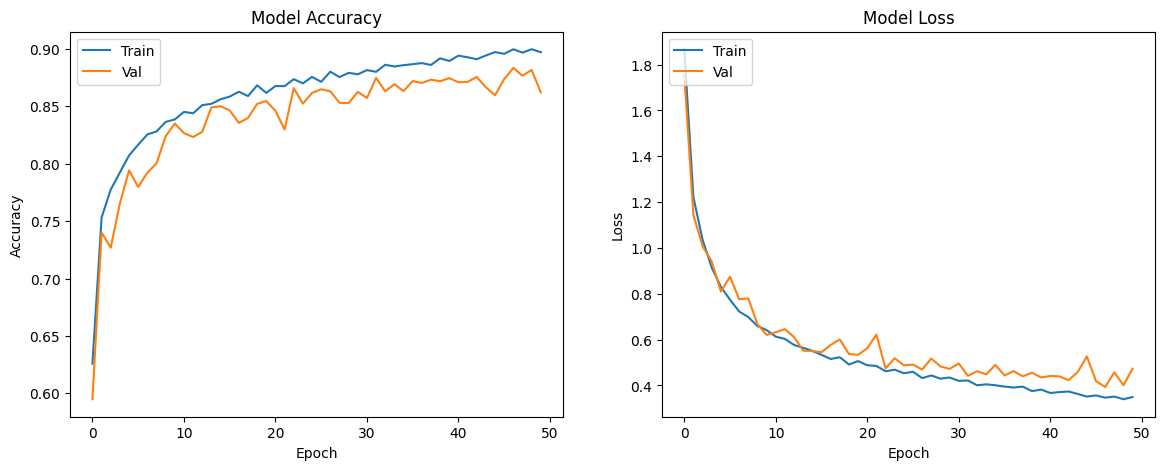

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 843ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2024-07-17 04:39:23.875268: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/tmp/ipykernel_6890/835103641.py:21: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


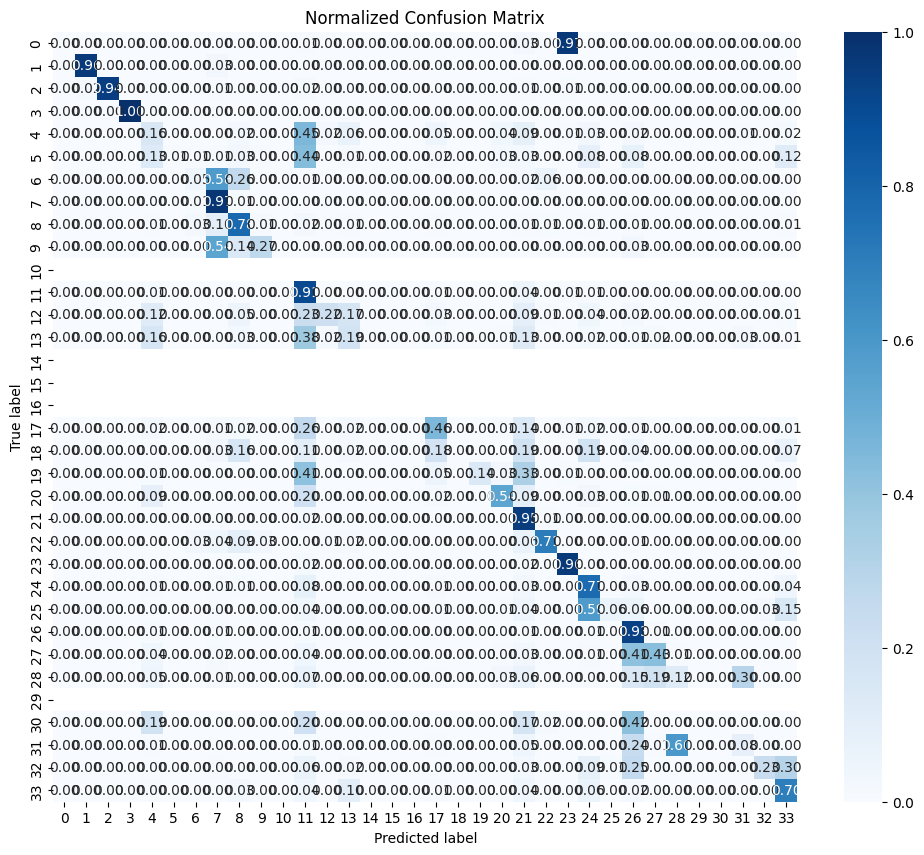

In [11]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = []
pred_labels = []

for images, labels in val_dataset.take(10):
    preds = model.predict(images)
    preds = np.argmax(preds, axis=-1)
    true_labels.extend(labels.numpy().flatten())
    pred_labels.extend(preds.flatten())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

cm = confusion_matrix(true_labels, pred_labels, labels=unique_class_ids)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_class_ids, yticklabels=unique_class_ids)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


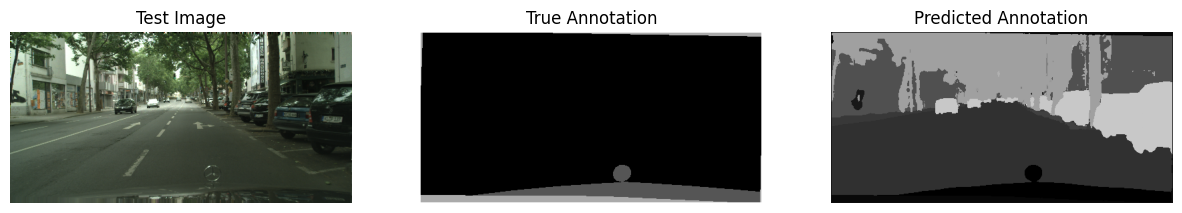

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, label_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.squeeze(label, axis=-1)

    return image, label

# Paths to test images and labels
test_images_dir = os.path.join(data_dir, 'leftImg8bit/test')
test_labels_dir = os.path.join(data_dir, 'gtFine/test')

test_image_paths = [os.path.join(test_images_dir, city, f) for city in os.listdir(test_images_dir) for f in os.listdir(os.path.join(test_images_dir, city)) if f.endswith('_leftImg8bit.png')]
test_label_paths = [p.replace('_leftImg8bit.png', '_gtFine_labelIds.png').replace('leftImg8bit', 'gtFine') for p in test_image_paths]

index = 5
test_image_path = test_image_paths[index]
test_label_path = test_label_paths[index]

test_image, test_label = load_and_preprocess_image(test_image_path, test_label_path)

test_image_batch = tf.expand_dims(test_image, axis=0)
predicted_annotation = model.predict(test_image_batch)
predicted_annotation = np.argmax(predicted_annotation, axis=-1).squeeze()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(test_image.numpy().astype('uint8'))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('True Annotation')
plt.imshow(test_label.numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Predicted Annotation')
plt.imshow(predicted_annotation, cmap='gray')
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


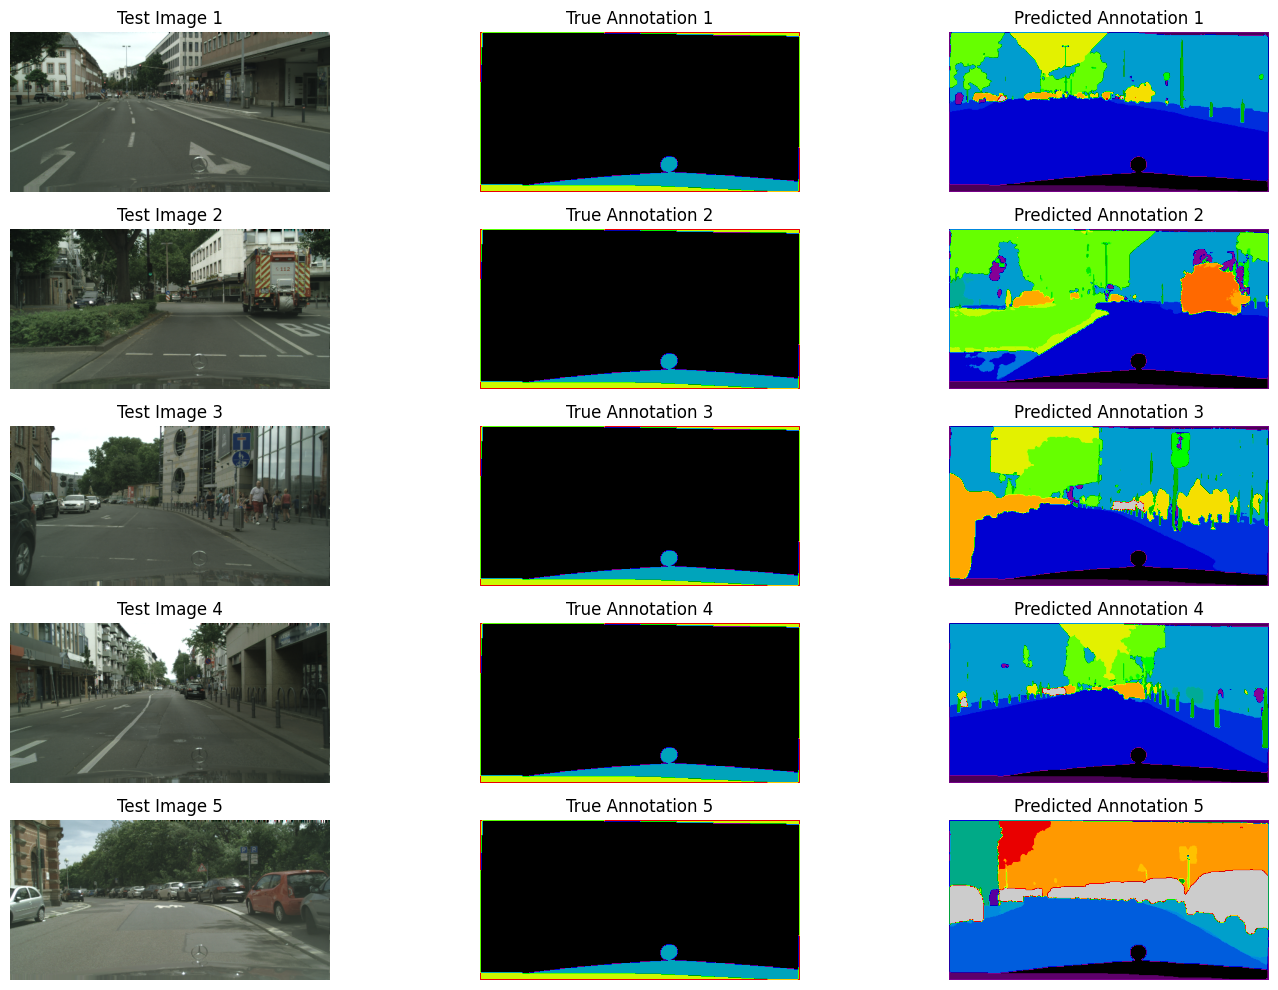

In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the function to load and preprocess a single image and its annotation
def load_and_preprocess_image(image_path, label_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.squeeze(label, axis=-1)

    return image, label

# Paths to test images and labels
test_images_dir = os.path.join(data_dir, 'leftImg8bit/test')
test_labels_dir = os.path.join(data_dir, 'gtFine/test')

# Get a list of all test images and labels
test_image_paths = [os.path.join(test_images_dir, city, f) for city in os.listdir(test_images_dir) for f in os.listdir(os.path.join(test_images_dir, city)) if f.endswith('_leftImg8bit.png')]
test_label_paths = [p.replace('_leftImg8bit.png', '_gtFine_labelIds.png').replace('leftImg8bit', 'gtFine') for p in test_image_paths]

# Select 5 test images
indices = [0, 1, 2, 3, 4]  # Change indices as needed

plt.figure(figsize=(15, 10))

for i, index in enumerate(indices):
    # Load and preprocess a single test image and label
    test_image_path = test_image_paths[index]
    test_label_path = test_label_paths[index]

    test_image, test_label = load_and_preprocess_image(test_image_path, test_label_path)

    # Predict the annotation for the test image
    test_image_batch = tf.expand_dims(test_image, axis=0)  # Add batch dimension
    predicted_annotation = model.predict(test_image_batch)
    predicted_annotation = np.argmax(predicted_annotation, axis=-1).squeeze()

    # Display the test image, true annotation, and predicted annotation
    plt.subplot(5, 3, i*3 + 1)
    plt.title(f'Test Image {i+1}')
    plt.imshow(test_image.numpy().astype('uint8'))
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.title(f'True Annotation {i+1}')
    plt.imshow(test_label.numpy(), cmap='nipy_spectral')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.title(f'Predicted Annotation {i+1}')
    plt.imshow(predicted_annotation, cmap='nipy_spectral')
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


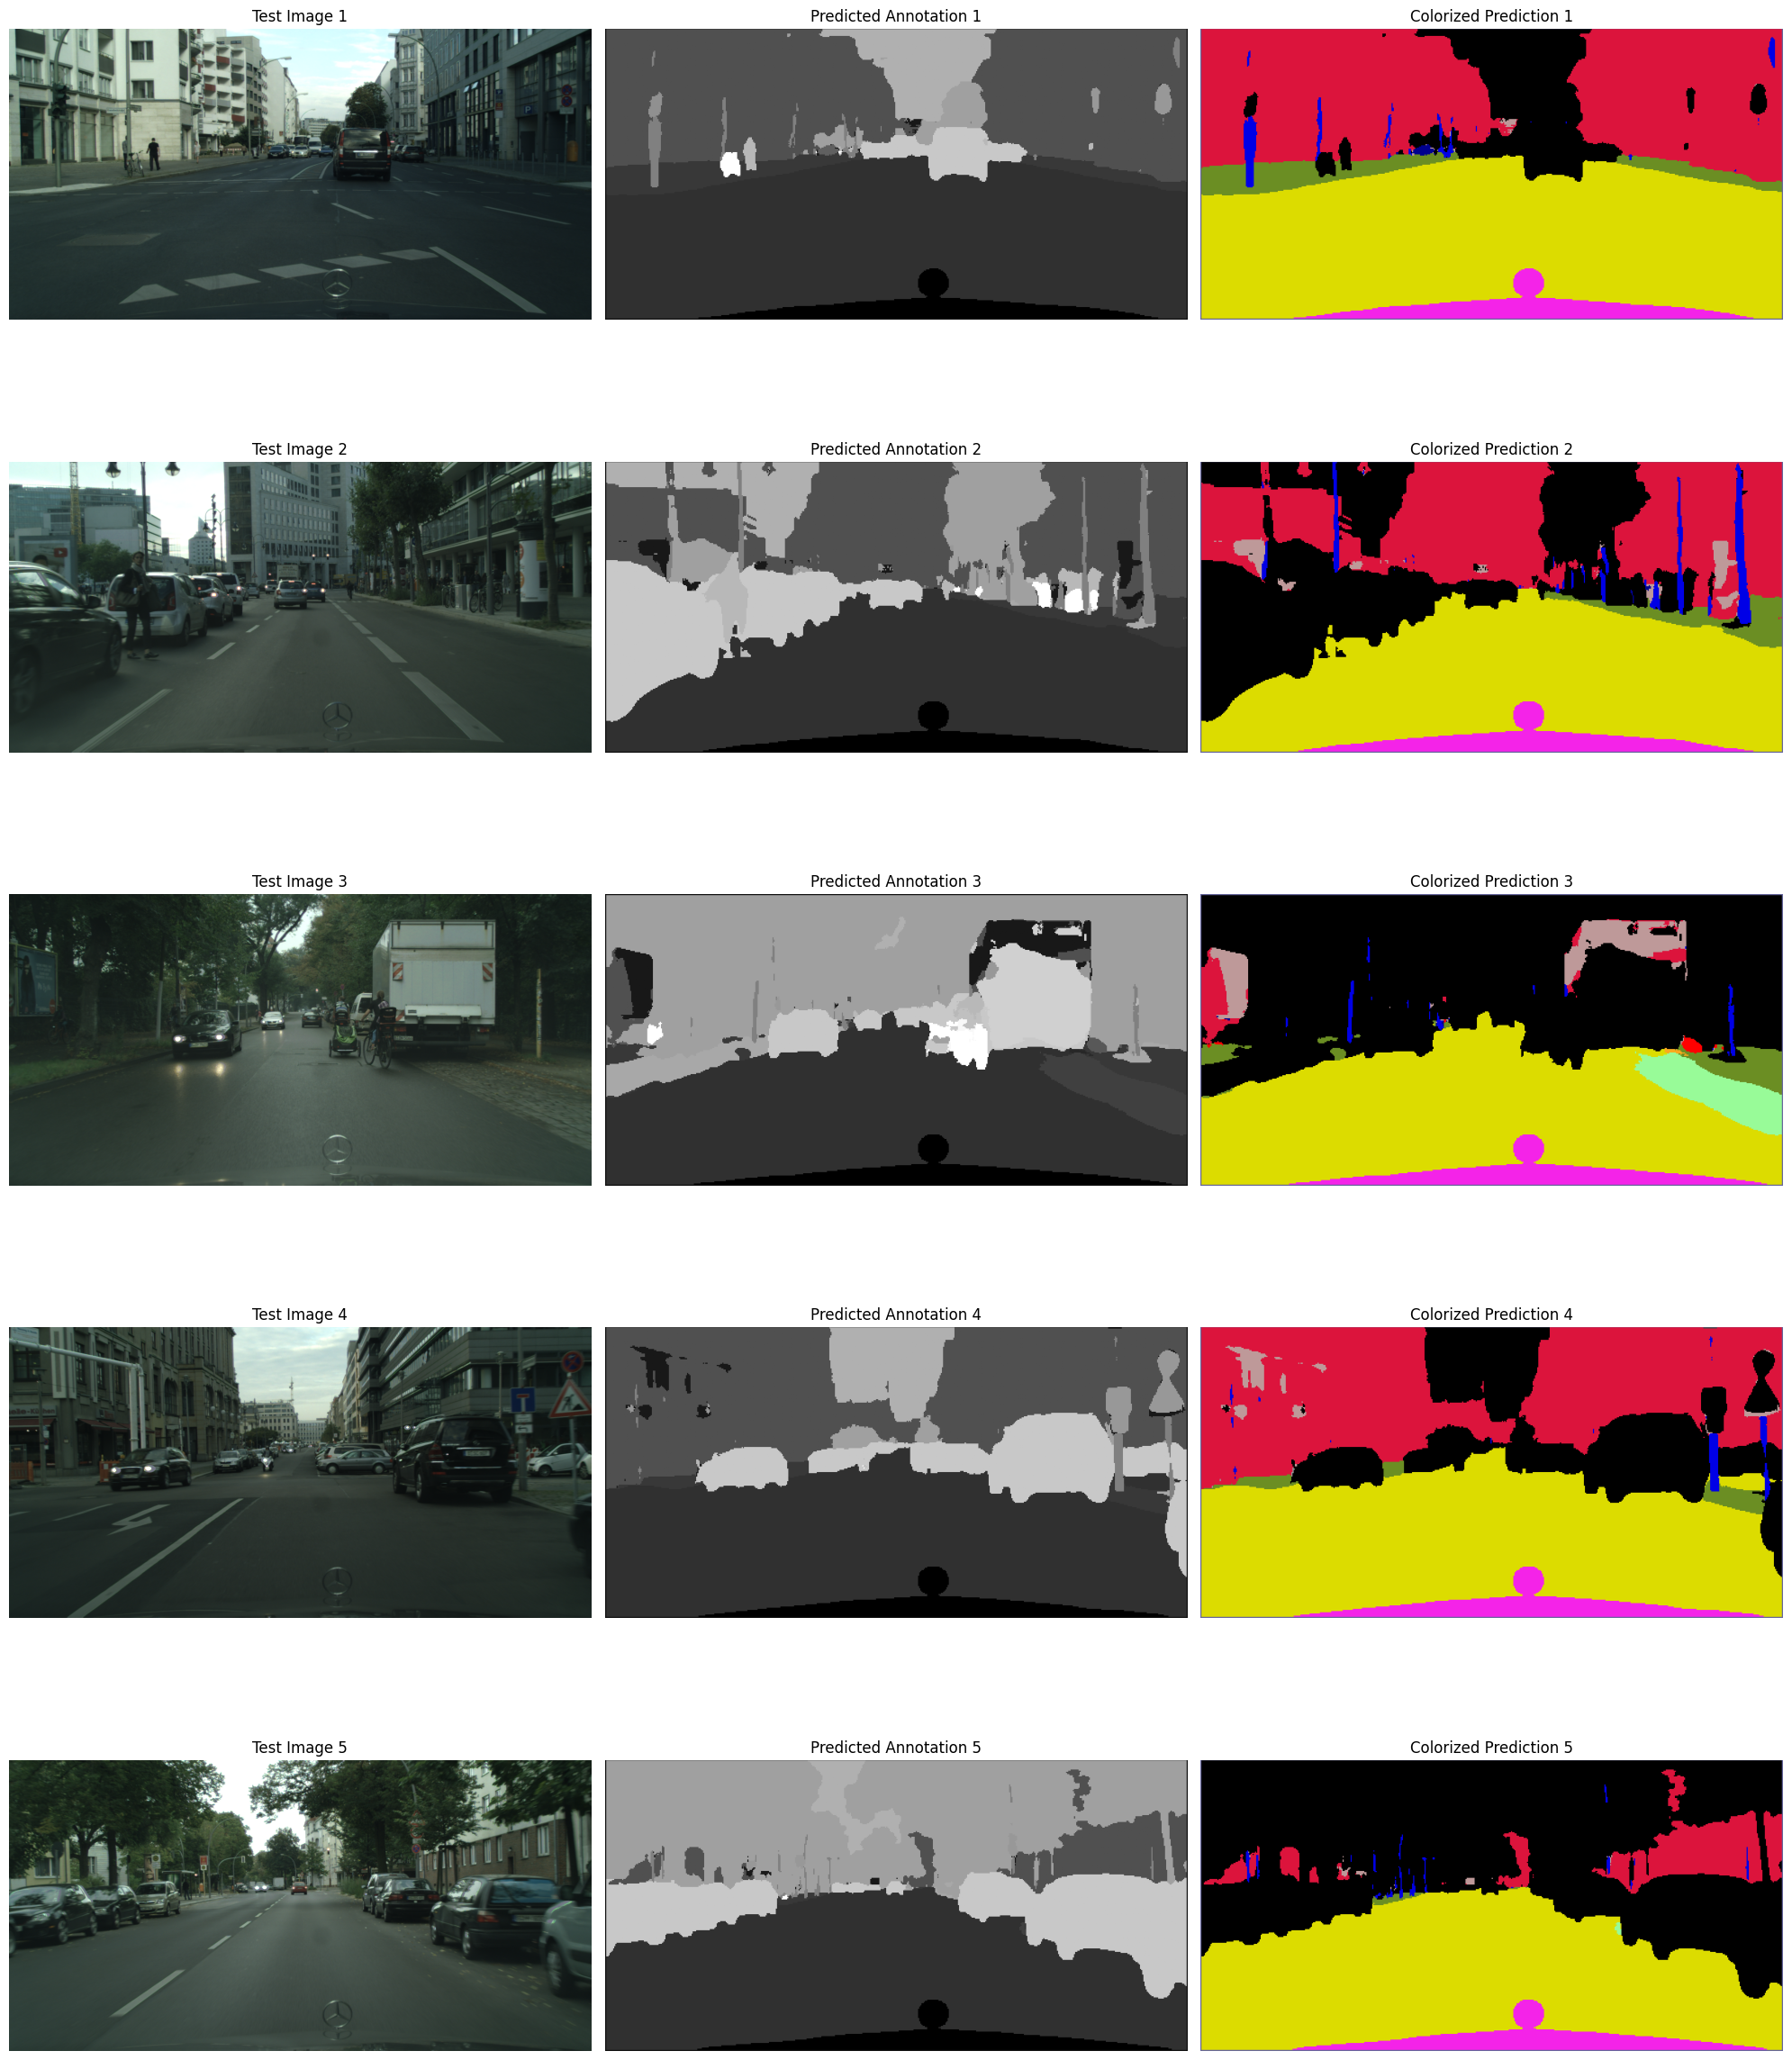

In [15]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the color map for Cityscapes
cityscapes_colors = {
    0: (128, 64, 128),  # road
    1: (244, 35, 232),  # sidewalk
    2: (70, 70, 70),    # building
    3: (102, 102, 156), # wall
    4: (190, 153, 153), # fence
    5: (153, 153, 153), # pole
    6: (250, 170, 30),  # traffic light
    7: (220, 220, 0),   # traffic sign
    8: (107, 142, 35),  # vegetation
    9: (152, 251, 152), # terrain
    10: (70, 130, 180), # sky
    11: (220, 20, 60),  # person
    12: (255, 0, 0),    # rider
    13: (0, 0, 142),    # car
    14: (0, 0, 70),     # truck
    15: (0, 60, 100),   # bus
    16: (0, 80, 100),   # train
    17: (0, 0, 230),    # motorcycle
    18: (119, 11, 32),  # bicycle
    19: (0, 0, 0)       # ego vehicle
}

def create_color_mask(mask):
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_id, color in cityscapes_colors.items():
        color_mask[mask == class_id] = color
    return color_mask

def visualize_predictions(model, test_images, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(20, num_images * 5))
    random_indices = random.sample(range(len(test_images)), num_images)

    for i, idx in enumerate(random_indices):
        test_image_path = test_images[idx]
        test_image = tf.image.decode_image(tf.io.read_file(test_image_path))
        test_image = tf.image.resize(test_image, (256, 512))
        test_image = tf.expand_dims(test_image, axis=0)
        
        pred_mask = model.predict(test_image)
        pred_mask = np.argmax(pred_mask, axis=-1)[0]
        pred_color_mask = create_color_mask(pred_mask)

        axes[i, 0].imshow(plt.imread(test_image_path))
        axes[i, 0].set_title(f"Test Image {i + 1}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(pred_mask, cmap='gray')
        axes[i, 1].set_title(f"Predicted Annotation {i + 1}")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_color_mask)
        axes[i, 2].set_title(f"Colorized Prediction {i + 1}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
test_images_dir = '/home/maith/Desktop/cityscapes/leftImg8bit/test'
test_image_paths = [os.path.join(test_images_dir, city, f) for city in os.listdir(test_images_dir) for f in os.listdir(os.path.join(test_images_dir, city)) if f.endswith('_leftImg8bit.png')]

visualize_predictions(model, test_image_paths)

In [16]:
from tensorflow.keras.models import load_model
import tensorflow as tf

model_path = '/home/maith/Desktop/cityscapes/best_model.keras'
model = load_model(model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

def representative_data_gen():
    for input_value, _ in val_dataset.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_gen

tflite_quant_model = converter.convert()

tflite_model_path = 'quantized_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_quant_model)
print(f"Model quantized and saved as {tflite_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmpas15ihiq/assets


INFO:tensorflow:Assets written to: /tmp/tmpas15ihiq/assets


Saved artifact at '/tmp/tmpas15ihiq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 512, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 256, 512, 34), dtype=tf.float32, name=None)
Captures:
  133581716074768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581716076688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581716075728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581716077072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581716077264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581716074576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581133159248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581133160016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581133155600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133581133159824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1335

/home/maith/Desktop/cityscapes/enet_cityscapes/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1721185477.845336    6890 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721185477.845349    6890 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-07-17 05:04:37.845476: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpas15ihiq
2024-07-17 05:04:37.847672: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-07-17 05:04:37.847692: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpas15ihiq
2024-07-17 05:04:37.875011: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-07-17 05:04:38.120798: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel b